In [1]:
%load_ext autoreload
%autoreload 2
import os

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

import mujoco
from mujoco import mjx

from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
from dm_control.mujoco.wrapper.mjbindings import enums
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import h5py
import jax.numpy as jp
import numpy as np 
import matplotlib.pyplot as plt
from typing import List, Union
from pathlib import Path
from omegaconf import DictConfig, OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import brax.math as brax_math

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
from matplotlib.animation import FuncAnimation, FFMpegWriter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from tqdm import tqdm
import cv2
warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from pathlib import Path

import time
import mediapy as media

from IPython.display import clear_output
clear_output()

In [92]:
mjcf_path = './models/arm_model_v3_torque.xml'
mjcf_element = mjcf.from_path(mjcf_path)
physics = mjcf.Physics.from_mjcf_model(mjcf_element)
mj_data = mujoco.MjData(physics.model.ptr)

In [93]:
for i in range(10):
    for j in range(20):
        a = physics.model.id2name(i, j)
        if a: print(f'{i, j} {a}')

(0, 1) world
(0, 2) world
(0, 3) sh_elv
(0, 5) target
(0, 6) Pec_C_Origin
(0, 7) my_camera
(0, 8) //unnamed_light_0
(0, 10) Bone_Scapula_right_v3
(0, 13) //unnamed_texture_0
(0, 14) target
(0, 19) sh_elv_act
(1, 1) ground
(1, 2) ground
(1, 3) sh_extension
(1, 5) //unnamed_geom_1
(1, 6) AD_Origin
(1, 7) my_camera1
(1, 10) Bone_Humerus_right_v3
(1, 13) grid
(1, 14) grid
(1, 19) sh_extension_act
(2, 1) clavicle
(2, 2) clavicle
(2, 3) sh_rotation
(2, 5) //unnamed_geom_2
(2, 6) Lat_Origin
(2, 10) Bone_Clavicle_right_v3
(2, 19) sh_rotation_act
(3, 1) scapula
(3, 2) scapula
(3, 3) elbow
(3, 5) //unnamed_geom_3
(3, 6) PD_Origin
(3, 10) Bone_Ulna_right_v3
(3, 19) elbow_act
(4, 1) humerus
(4, 2) humerus
(4, 5) //unnamed_geom_4
(4, 6) MD_Origin
(4, 10) Bone_Radius_right_v3
(5, 1) ulna
(5, 2) ulna
(5, 5) elbow_marker
(5, 6) Triceps_Long_Origin
(5, 10) Bone_Segments_Hand
(6, 1) radius
(6, 2) radius
(6, 5) //unnamed_geom_6
(6, 6) Biceps_Long_Origin
(7, 1) hand
(7, 2) hand
(7, 5) //unnamed_geom_7
(7,

In [94]:
print(physics.model.name2id("hand", "body"))
print(physics.model.name2id("scapula", "body"))
print(physics.model.name2id("elbow_marker", "geom"))

7
3
5


In [95]:
physics.named.model.body_pos
# physics.named.model.geom_pos
# physics.named.model.site_pos

FieldIndexer(body_pos):
             x         y         z         
0    world [ 0         0         0       ]
1   ground [ 0         0         0       ]
2 clavicle [ 0         0         0       ]
3  scapula [-0.0001   -0.0001    0.0005  ]
4  humerus [ 0         0.0007   -0.0002  ]
5     ulna [-0.0005    0.0003   -0.0068  ]
6   radius [ 0.00035   0.0002    0.0002  ]
7     hand [ 0.003     0.0005   -0.009   ]

### Get the positions of hand, elbow, and scapula with dm_control mujoco

In [ ]:
# step forward in the model
mujoco.mj_kinematics(physics.model.ptr, mj_data)

# get coordinates of the model
scapula_idx = physics.model.name2id('scapula', 'body')
scapula_pos = physics.data.xpos[scapula_idx]

elbow_idx = physics.model.name2id('elbow_marker', 'geom')
elbow_pos = physics.data.geom_xpos[5]

hand_idx = physics.model.name2id('hand', 'body')
hand_pos = physics.data.xpos[hand_idx]

mujoco_arm_coords = np.concatenate([scapula_pos, elbow_pos, hand_pos]).reshape(-1, 3)
mujoco_arm_coords.shape

(3, 3)

In [109]:
with h5py.File("./tests/data/points3d_transformed_shorten.h5", 'r') as f:
    sleap_coords = f["tracks"][0][0]

In [110]:
# mujoco_arm_coords
sleap_coords

array([[-6.11255223, 10.60458006, 13.56400908],
       [-8.81604535, 11.9665426 ,  5.03752033],
       [ 1.26819147,  8.95696416,  3.92618692]])

In [136]:
mujoco_arm_coords

array([[-0.0001    , -0.0001    ,  0.0005    ],
       [ 0.0011889 , -0.00413805, -0.00495372],
       [ 0.0064878 , -0.01083974, -0.00897384]])

In [122]:
def plot_plane_and_points(points, fig=None, ax=None, color='r', label=''):
    """
    Plot the plane and the 3D points.
    
    Args:
        points (jax.numpy.ndarray): Array of shape (N, 3), the 3D points.
    """
    print('points',points.shape)
    
    # Compute the centroid of the points
    centroid = jp.mean(points, axis=0)
    
    # Center the points around the centroid
    centered_points = points - centroid
    
    # Compute the SVD of the centered points
    _, _, vh = jp.linalg.svd(centered_points, full_matrices=False)
    
    # The plane's normal is the singular vector corresponding to the smallest singular value
    normal = vh[-1]
    
    # Compute the intercept term (d) for the plane equation ax + by + cz + d = 0
    d = -jp.dot(normal, centroid)
    
    # Create a mesh grid for the plane
    x = jp.linspace(points[:, 0].min(), points[:, 0].max(), 10)
    y = jp.linspace(points[:, 1].min(), points[:, 1].max(), 10)
    x, y = jp.meshgrid(x, y)
    
    # Compute the corresponding z values for the plane equation ax + by + cz + d = 0
    z = (-normal[0] * x - normal[1] * y - d) / normal[2]
    
    # Plot the points and the plane
    if fig is None and ax is None:
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(points[0, 0], points[0, 1], points[0, 2], c='r', label=label+' Points')
    ax.scatter(points[1, 0], points[1, 1], points[1, 2], c='g', label=label+' Points')
    ax.scatter(points[2, 0], points[2, 1], points[2, 2], c='b', label=label+' Points')

    # Plot the plane
    ax.plot_surface(x, y, z, alpha=0.5, color=color, label=label + ' Plane')
    # ax.plot_surface(x, y, -.13*jp.ones_like(x), alpha=0.5, color='black', label='Ground Plane')
    
    # Set labels and title
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Fitted Plane and 3D Points")
    # ax.legend()

points (3, 3)


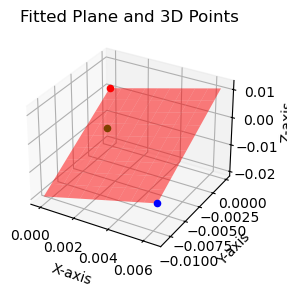

In [123]:
plot_plane_and_points(mujoco_arm_coords)

points (3, 3)


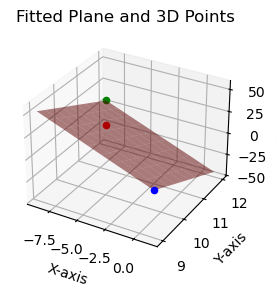

In [124]:
plot_plane_and_points(sleap_coords)

In [125]:
def procrustes_jax(source_points, target_points, floor=None):
    """
    Perform Procrustes analysis to align matrix source_points to matrix target_points.
    
    Parameters:
    source_points : (N, M) array_like
        The source input matrix.
    target_points : (N, M) array_like
        The reference/target input matrix.
    kp_idxs: (N,) array_like
        The indices of the keypoints to use for the alignment.
    floor : float, optional
    
    Returns:
    d : float
        The residual sum of squared errors.
    Z : (T,N, M) ndarray
        The matrix Y, transformed to best match X.
    R : (M, M) ndarray
        The rotation applied to Y.
    scale : float
        The scaling factor applied to Y.
    """
    
    # Center both matrices
    source_centered = source_points - jp.mean(source_points, axis=0)
    target_centered = target_points - jp.mean(target_points, axis=0)

    # Normalize the Frobenius norm to 1
    target_norm = jp.linalg.norm(target_centered)
    source_norm = jp.linalg.norm(source_centered)
    target_centered /= target_norm
    source_centered /= source_norm

    # Compute the optimal rotation matrix using Singular Value Decomposition (SVD) for the first frame
    U, _, Vt = jp.linalg.svd(jp.dot(target_centered.T, source_centered).T)
    R = jp.dot(U, Vt)

    # Apply the rotation and scaling to all frames
    scale = target_norm / source_norm
    Z = jp.dot(source_points, R) * scale
    d = jp.sum(jp.square(target_centered - Z))

    return d, Z, R, scale

In [126]:
d, Z, R, scale = procrustes_jax(
    source_points=sleap_coords,
    target_points=mujoco_arm_coords)

points (3, 3)


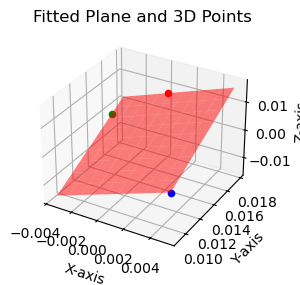

In [133]:
plot_plane_and_points(Z)

### Get the positions of hand, elbow, and scapula with dm_control mujoco + mjx

In [139]:
mjx_model = mjx.put_model(physics.model.ptr)
mjx_data = mjx.make_data(mjx_model)
mjx_data = mjx.kinematics(mjx_model, mjx_data)
mjx_data = mjx.com_pos(mjx_model, mjx_data)

In [148]:
print("frobenius norm of the matrices whose data points are the arm bodies: \n(comparing mjx vs mujoco)")
print(jp.linalg.norm(mjx_data.xpos - physics.data.xpos))


frobenius norm of the matrices whose data points are the arm bodies: 
(comparing mjx vs mujoco)
4.402599e-09


In [144]:
physics.data.xpos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e-04, -1.00000000e-04,  5.00000000e-04],
       [-4.82361910e-05,  4.09625200e-04, -1.73032607e-05],
       [ 1.18889709e-03, -4.13804616e-03, -4.95371759e-03],
       [ 1.50802426e-03, -3.82079495e-03, -4.95063254e-03],
       [ 6.48780131e-03, -1.08397448e-02, -8.97383569e-03]])

In [ ]:
# todo1: apply the procustes alignment through the entire provided h5 dataset
# todo2: visualize the output
# todo3: implement to stac folder, submit pr

In [4]:
# unsqueeze dim 1 of mujoco_aligned_tracking
with h5py.File("./tests/data/mujoco_aligned_tracking.h5", 'r') as f:

    data = f['tracks'][:]

In [15]:
print('hi')

hi


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from tqdm import tqdm
import cv2

def plotter(points3d):

    # Define skeleton connections (edges)
    connections = [(0, 1), (1, 2)]
    nodes = ["shoulder", "elbow", "wrist"]

    # Create a directory to store frames
    output_dir = "skeleton_frames"
    os.makedirs(output_dir, exist_ok=True)

    # Define start frame and number of frames to process
    start_frame = 300
    num_frames = 10
    end_frame = start_frame + num_frames

    # Compute global axis limits
    x_min = points3d[:, :, :, 0].min()
    x_max = points3d[:, :, :, 0].max()
    y_min = points3d[:, :, :, 1].min()
    y_max = points3d[:, :, :, 1].max()
    z_min = points3d[:, :, :, 2].min()
    z_max = points3d[:, :, :, 2].max()

    # Iterate over selected frames and tracks
    num_tracks = points3d.shape[1]  # Number of tracks
    for frame_idx in tqdm(range(start_frame, end_frame), desc="Generating frames"):
        for track_idx in range(num_tracks):
            # Get the coordinates for the selected frame and track
            coords = points3d[frame_idx, track_idx]  # Shape: (3, 3)

            # Plot the skeleton
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            # Plot each node
            for i in range(3):
                ax.scatter(coords[i, 0], coords[i, 1], coords[i, 2], label=f'Node {nodes[i]}')

            # Plot the skeleton connections
            for start, end in connections:
                ax.plot(
                    [coords[start, 0], coords[end, 0]],  # x-coordinates
                    [coords[start, 1], coords[end, 1]],  # y-coordinates
                    [coords[start, 2], coords[end, 2]],  # z-coordinates
                    'k-', linewidth=2  # Black line for the skeleton
                )

            # Set consistent axis limits
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_zlim(z_min, z_max)

            # Add labels and a legend
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()
            plt.title(f"Skeleton for Frame {frame_idx}, Track {track_idx}")

            # Save the frame
            frame_path = os.path.join(output_dir, f"frame_{frame_idx:04d}_track_{track_idx:02d}.png")
            plt.savefig(frame_path)
            plt.close(fig)

    # Compile frames into a video using OpenCV
    output_video = "input_vs_output.mp4"
    frame_paths = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".png")])

    # Define video writer
    frame = cv2.imread(frame_paths[0])
    height, width, _ = frame.shape
    # fourcc = cv2.VideoWriter_fourcc(*'MJPG')  # Codec for mp4
    fourcc = cv2.VideoWriter_fourcc(*'AVC1')  # Codec for mp4
    video_writer = cv2.VideoWriter(output_video, fourcc, 30, (width, height))

    # Write each frame to the video
    for frame_path in tqdm(frame_paths, desc="Creating video"):
        frame = cv2.imread(frame_path)
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video}")

plotter(data)

Generating frames: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]
OpenCV: FFMPEG: tag 0x31435641/'AVC1' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@595.388] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@595.388] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
Creating video: 100%|██████████| 100/100 [00:00<00:00, 189.30it/s]

Video saved to input_vs_output.mp4


Generating frames:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: a bytes-like object is required, not 'tuple'

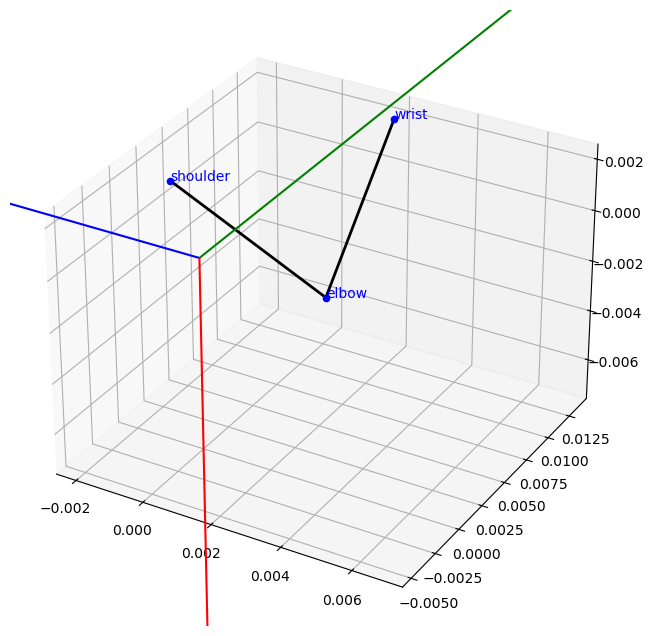

In [24]:
def plotter(points3d):
    # Define start frame and number of frames to process
    start_frame = 300
    num_frames = 10
    end_frame = start_frame + num_frames

    # Define skeleton connections (edges)
    connections = [(0, 1), (1, 2)]  # Adjust based on data structure
    nodes = ["shoulder", "elbow", "wrist"]  # Node names for visualization

    # Transformation matrix and origin (computed earlier)
    # transformation_matrix = np.vstack([x_axis, y_axis, z_axis]).T  # Stack as columns for proper alignment
    # origin = (barL_points.mean(axis=0) + barR_points.mean(axis=0)) / 2  # Wall origin

    # Transform all reaching points
    # points3d_centered = points3d - origin  # Center the points to the new origin
    # points3d_transformed = np.einsum('...j,kj->...k', points3d_centered, transformation_matrix)  # Apply transformation
    # points3d_transformed[..., 2] *= -1  # Flip the Z-axis

    # Compute global axis limits for transformed data
    x_min = points3d[..., 0].min()
    x_max = points3d[..., 0].max()
    y_min = points3d[..., 1].min()
    y_max = points3d[..., 1].max()
    z_min = points3d[..., 2].min()
    z_max = points3d[..., 2].max()

    # Prepare video writing
    output_video = "input_output.mp4"
    fps = 25  # Frames per second

    # Initialize video writer
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (fig.canvas.get_width_height()[::-1]))

    for frame_idx in tqdm(range(start_frame, end_frame), desc="Generating frames"):
        ax.clear()

        # Plot new coordinate axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='blue', length=5, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 1, 0, color='green', length=5, arrow_length_ratio=0.1)
        ax.quiver(0, 0, 0, 0, 0, 1, color='red', length=5, arrow_length_ratio=0.1)

        for track_idx in range(points3d.shape[1]):  # Iterate over tracks
            # Get transformed coordinates for the selected frame and track
            coords = points3d[frame_idx, track_idx]

            # Plot nodes
            for i in range(3):
                ax.scatter(coords[i, 0], coords[i, 1], coords[i, 2], c='b')
                ax.text(coords[i, 0], coords[i, 1], coords[i, 2], f"{nodes[i]}", fontsize=10, color="blue")

            # Plot skeleton connections
            for start, end in connections:
                ax.plot(
                    [coords[start, 0], coords[end, 0]],
                    [coords[start, 1], coords[end, 1]],
                    [coords[start, 2], coords[end, 2]],
                    'k-', linewidth=2
                )

        # Maintain consistent axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

        # Render the frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.print_to_buffer(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    plt.close(fig)

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video}")

plotter(data)

In [ ]:
import matplotlib
# print(matplotlib.__version__)

3.10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2

# Define video parameters
frame_width = 640
frame_height = 480
fps = 30  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Use 'XVID' or 'H264' for better quality

# Create the VideoWriter object
out = cv2.VideoWriter('animated_plot.mp4', fourcc, fps, (frame_width, frame_height))

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(6.4, 4.8))  # Size in inches (width, height)

# Prepare data for animation
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Create canvas
canvas = FigureCanvas(fig)

# Loop through to generate video frames
for i in tqdm(range(100)):
    ax.clear()  # Clear the previous plot
    
    # Update plot data (make the sine wave "move")
    ax.plot(x, np.sin(x + 0.1 * i))  # Shift the sine wave over time
    
    # Set axis labels
    ax.set_title('Animated Sine Wave')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Redraw the canvas
    canvas.draw()

    # Convert figure to RGBA image
    image_rgba = canvas.buffer_rgba()

    # Convert RGBA to RGB (remove alpha channel)
    image_np = np.frombuffer(image_rgba, dtype=np.uint8).reshape(frame_height, frame_width, 4)[:, :, :3]

    # Write frame to video file
    out.write(image_np)

# Release the video writer object and close the figure
out.release()
plt.close(fig)


  4%|▍         | 4/100 [00:00<00:05, 18.60it/s]

In [11]:
import cv2
print(cv2.getBuildInformation())



General configuration for OpenCV 4.11.0 =====================================
  Version control:               4.11.0-dirty

  Platform:
    Timestamp:                   2025-01-16T09:53:30Z
    Host:                        Linux 5.15.0-1074-azure x86_64
    CMake:                       3.31.1
    CMake generator:             Unix Makefiles
    CMake build tool:            /bin/gmake
    Configuration:               Release
    Algorithm Hint:              ALGO_HINT_ACCURATE

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      AVX (8 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      FP16 (0 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 AVX FP16
      AVX2 (36 files):           + SSSE3 SSE4_1 POPCNT SSE4_2 AVX FP16 AVX2 FMA3
      AVX512_S

In [12]:
cap = cv2.VideoCapture('animated_plot.avi')
if not cap.isOpened():
    print("Error opening video file.")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Animated Plot', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

: 